In [26]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
import time
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip


# Step 0 - Resourcing Stuff from the Galaxy Metadata #

Certain parameters relevant to our research are sourced as part of the DESI metadata file (things are roughly scattered between fastspecfit and the metadata content). We have to start from the very beginning and resource metadata again and move on to the fastspecfit files. 

In [ ]:
# Paths
fits_path = "/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron-main-bright.fits"
output_path = "DES5YR_DESI_match_data/desi_galaxy_metadata.fits"

start = time.time()

# DATA NEEDED FOR ANALYSIS
with fits.open(fits_path, memmap=True) as hdul:
    metadata = Table(hdul["METADATA"].data)
    galaxy_rows = metadata[metadata["SPECTYPE"] == "GALAXY"]
    trimmed = galaxy_rows[["TARGETID", "RA", "DEC", "DESI_TARGET", "SPECTYPE", "Z", "ZWARN"]]

# Save
trimmed.write(output_path, overwrite=True)

end = time.time()
print(f"\n⏳ Total time: {end - start:.2f} seconds")

# Load and display saved file summary
with fits.open(output_path) as hdul_out:
    print(f"\n📁 Output file: {output_path}")
    print("📋 Columns:", hdul_out[1].columns.names)
    print("🧾 First few rows:")
    print(Table(hdul_out[1].data[:5]))  # display first 5 rows

# Step 1 #

Take `ZTF_snia_match_DESI_hostgal_Z_filtered.csv` which has the lightcurve parameters and the DESI `TARGETID`. This .csv contains the SNIa that were originally matched between ZTF and the DESI galaxy surveys.

And to that simply add the matching `ZTF_residuals_centered.csv` and only add the `residual_centered` collumn.

Thus combining into a new data file called `ZTF_snia_match_DESI_hostgal_Z_filtered_mu_residuals.csv`. 

In [44]:
# Step 1 — File paths
path_main = "ZTF_DESI_data/ZTF_snia_match_DESI_hostgal_Z_filtered.csv"
path_resid = "ZTF_DESI_data/ZTF_residuals_centered.csv"
output_path = "ZTF_DESI_data/ZTF_snia_match_DESI_hostgal_Z_filtered_mu_residuals.csv"

# Step 2 — Read both datasets
df_main = pd.read_csv(path_main)
df_resid = pd.read_csv(path_resid)

# Step 3 — Merge only the 'residual_centered' column on 'ztfname'
df_merged = df_main.merge(df_resid[['ztfname', 'residual_centered']], on='ztfname', how='left')

# Step 4 — Save to new CSV
df_merged.to_csv(output_path, index=False)

print(f"✅ Combined dataset saved to: {output_path}")
print(f"🧾 Shape: {df_merged.shape}")

✅ Combined dataset saved to: ZTF_DESI_data/ZTF_snia_match_DESI_hostgal_Z_filtered_mu_residuals.csv
🧾 Shape: (776, 49)


# DARK GALAXIES BULK FILE #

So in the following strategy we will try to get the data that we need by reading TargetID's from the following .fits files:

`desi_galaxy_metadata.fits` (which means that "bright" is implied) and `desi_galaxy_metadata_dark.fits` (where "dark is in the name)

And search them for their TARGETID's. This is really good because these .fits files have already been filtered by "Galaxies". 

We will take relevant galactic properties from the ` 📁 HDU 1: FASTSPEC` and save them in another fits file.

This strategy is mainly emloyed because when trying to serach all of `HDU 1: FASTSPEC` from just a .CSV file of `ZTF_snia_match_DESI_hostgal_Z_filtered_mu_residuals.csv` and found that this crashed the kernel. 

So it would be easier to just get a .fits file of ALL releavan desi galaxy metadata, save it, and then use the .csv to search for all these types of things. 



In [1]:
import time
import numpy as np
from astropy.table import Table

# ---------------------------------------------
# Paths
# ---------------------------------------------
meta_path = "DES5YR_DESI_data/desi_galaxy_metadata_dark.fits" # Automatically implies that this is bright.
fastspec_path = "/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron-main-dark.fits"
output_host_path = "ZTF_DESI_data/desi_galaxy_fastspec_hostprops_dark.fits"

start = time.time()

# ---------------------------------------------
# 1. Read the pre-trimmed galaxy metadata file
# ---------------------------------------------
print(f"Reading metadata from: {meta_path}")
meta = Table.read(meta_path, hdu=1)  # your trimmed file has the table in HDU 1

print("Metadata columns:", meta.colnames)
print("Metadata length:", len(meta))

# Ensure TARGETID is integer and get unique list
meta["TARGETID"] = meta["TARGETID"].astype("int64")
targetids = np.unique(meta["TARGETID"])
print("Unique TARGETIDs in metadata:", len(targetids))

# ---------------------------------------------
# 2. Read only the needed columns from FASTSPEC
# ---------------------------------------------
desired_host_cols = [
    "TARGETID",
    "VDISP",
    "LOGMSTAR", 
    "SFR",
    "DN4000",
    "AGE",
    "ZZSUN",
    "FOII_3727_CONT",
    "FHBETA_CONT",
    "FOIII_5007_CONT",
    "FHALPHA_CONT",
    "ABSMAG01_SDSS_G",
    "ABSMAG01_SDSS_R",
    "ABSMAG01_SDSS_U"
    
]

print(f"\nReading FASTSPEC from: {fastspec_path}")
print("Requested columns:", desired_host_cols)

# Read from the FASTSPEC HDU, only these columns
fastspec = Table.read(
    fastspec_path,
    hdu="FASTSPEC",       # HDU name you mentioned
)

# ⬇️ Add this line to keep only the host properties you want
fastspec = fastspec[desired_host_cols]

# print("FASTSPEC shape (selected cols):", fastspec.shape)
# print("FASTSPEC columns actually read:", fastspec.colnames)

# Make sure TARGETID is int64 to match metadata
fastspec["TARGETID"] = fastspec["TARGETID"].astype("int64")

# ---------------------------------------------
# 3. Filter FASTSPEC rows to those in metadata TARGETIDs
# ---------------------------------------------
mask = np.in1d(fastspec["TARGETID"], targetids)
fastspec_sub = fastspec[mask]

print("\nFASTSPEC rows matching metadata TARGETIDs:", len(fastspec_sub))

# ---------------------------------------------
# 4. Save trimmed host properties to a new FITS
# ---------------------------------------------
fastspec_sub.write(output_host_path, overwrite=True)

end = time.time()
print(f"\n✅ Saved trimmed host-properties table to:\n  {output_host_path}")
print(f"⏳ Total time: {end - start:.2f} seconds")

# ---------------------------------------------
# 5. Quick sanity check of the output file
# ---------------------------------------------
print("\n🔍 Inspecting saved host-properties file...")
host_check = Table.read(output_host_path, hdu=1)
print("Output columns:", host_check.colnames)
print("Output length:", len(host_check))
print("First 5 rows:")
print(host_check[:5])

SyntaxError: unterminated string literal (detected at line 40) (3557465408.py, line 40)

# BRIGHT GALAXIES BULK FILE #

So in the following strategy we will try to get the data that we need by reading TargetID's from the following .fits files:

`desi_galaxy_metadata.fits` (which means that "bright" is implied) and `desi_galaxy_metadata_dark.fits` (where "dark is in the name)

And search them for their TARGETID's. This is really good because these .fits files have already been filtered by "Galaxies". 

We will take relevant galactic properties from the ` 📁 HDU 1: FASTSPEC` and save them in another fits file.

This strategy is mainly emloyed because when trying to serach all of `HDU 1: FASTSPEC` from just a .CSV file of `ZTF_snia_match_DESI_hostgal_Z_filtered_mu_residuals.csv` and found that this crashed the kernel. 

So it would be easier to just get a .fits file of ALL releavan desi galaxy metadata, save it, and then use the .csv to search for all these types of things. 



In [2]:
import time
import numpy as np
from astropy.table import Table

# ---------------------------------------------
# Paths
# ---------------------------------------------
meta_path = "DES5YR_DESI_data/desi_galaxy_metadata.fits"
fastspec_path = "/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron-main-bright.fits"
output_host_path = "ZTF_DESI_data/desi_galaxy_fastspec_hostprops_bright.fits"

start = time.time()

# ---------------------------------------------
# 1. Read the pre-trimmed galaxy metadata file
# ---------------------------------------------
print(f"Reading metadata from: {meta_path}")
meta = Table.read(meta_path, hdu=1)  # your trimmed file has the table in HDU 1

print("Metadata columns:", meta.colnames)
print("Metadata length:", len(meta))

# Ensure TARGETID is integer and get unique list
meta["TARGETID"] = meta["TARGETID"].astype("int64")
targetids = np.unique(meta["TARGETID"])
print("Unique TARGETIDs in metadata:", len(targetids))

# ---------------------------------------------
# 2. Read only the needed columns from FASTSPEC
# ---------------------------------------------
desired_host_cols = [
    "TARGETID",
    "VDISP",
    "LOGMSTAR", 
    "SFR",
    "AGE",
    "DN4000",
    "ABSMAG01_SDSS_G",
    "ABSMAG01_SDSS_R"
]

print(f"\nReading FASTSPEC from: {fastspec_path}")
print("Requested columns:", desired_host_cols)

# Read from the FASTSPEC HDU, only these columns
fastspec = Table.read(
    fastspec_path,
    hdu="FASTSPEC",       # HDU name you mentioned
)

# ⬇️ Add this line to keep only the host properties you want
fastspec = fastspec[desired_host_cols]

# print("FASTSPEC shape (selected cols):", fastspec.shape)
# print("FASTSPEC columns actually read:", fastspec.colnames)

# Make sure TARGETID is int64 to match metadata
fastspec["TARGETID"] = fastspec["TARGETID"].astype("int64")

# ---------------------------------------------
# 3. Filter FASTSPEC rows to those in metadata TARGETIDs
# ---------------------------------------------
mask = np.in1d(fastspec["TARGETID"], targetids)
fastspec_sub = fastspec[mask]

print("\nFASTSPEC rows matching metadata TARGETIDs:", len(fastspec_sub))

# ---------------------------------------------
# 4. Save trimmed host properties to a new FITS
# ---------------------------------------------
fastspec_sub.write(output_host_path, overwrite=True)

end = time.time()
print(f"\n✅ Saved trimmed host-properties table to:\n  {output_host_path}")
print(f"⏳ Total time: {end - start:.2f} seconds")

# ---------------------------------------------
# 5. Quick sanity check of the output file
# ---------------------------------------------
print("\n🔍 Inspecting saved host-properties file...")
host_check = Table.read(output_host_path, hdu=1)
print("Output columns:", host_check.colnames)
print("Output length:", len(host_check))
print("First 5 rows:")
print(host_check[:5])

Reading metadata from: DES5YR_DESI_data/desi_galaxy_metadata.fits
Metadata columns: ['TARGETID', 'RA', 'DEC', 'DESI_TARGET', 'SPECTYPE', 'Z', 'ZWARN']
Metadata length: 6346725
Unique TARGETIDs in metadata: 6346725

Reading FASTSPEC from: /global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron-main-bright.fits
Requested columns: ['TARGETID', 'VDISP', 'LOGMSTAR', 'SFR', 'AGE', 'DN4000', 'ABSMAG01_SDSS_G', 'ABSMAG01_SDSS_R']

FASTSPEC rows matching metadata TARGETIDs: 6346725

✅ Saved trimmed host-properties table to:
  ZTF_DESI_data/desi_galaxy_fastspec_hostprops_bright.fits
⏳ Total time: 94.14 seconds

🔍 Inspecting saved host-properties file...
Output columns: ['TARGETID', 'VDISP', 'LOGMSTAR', 'SFR', 'AGE', 'DN4000', 'ABSMAG01_SDSS_G', 'ABSMAG01_SDSS_R']
Output length: 6346725
First 5 rows:
    TARGETID     VDISP  LOGMSTAR ...   DN4000   ABSMAG01_SDSS_G ABSMAG01_SDSS_R
---------------- ----- --------- ... ---------- --------------- ---------------
23687016

# Host Galaxy Parameters to the .csv with SNIa Resduals #

So now we hav the following file: `ZTF_snia_match_DESI_hostgal_Z_filtered_mu_residuals.csv` which contains the:

- `TARGETID`
- `residuals`

And we have 2 `.fits` files:

- `ZTF_DESI_data/desi_galaxy_fastspec_hostprops_bright.fits`
- `ZTF_DESI_data/desi_galaxy_fastspec_hostprops_dark.fits`


that contain the host galaxy parameters. All we have to do now is loop over the .csv file here and match up the host galaxy parameters from the fits files. 

In [8]:
import pandas as pd
from astropy.table import Table, vstack
from pathlib import Path

# ------------------------------------------------------------------
# File paths – tweak these if your layout is different
# ------------------------------------------------------------------

csv_path = "ZTF_DESI_data/ZTF_snia_match_DESI_hostgal_Z_filtered_mu_residuals.csv"
bright_fits_path = "ZTF_DESI_data/desi_galaxy_fastspec_hostprops_bright.fits"
dark_fits_path   = "ZTF_DESI_data/desi_galaxy_fastspec_hostprops_dark.fits"

# ------------------------------------------------------------------
# 1) Read the SN Ia + residuals CSV
# ------------------------------------------------------------------
sne_df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2) Read both FASTSPEC host-property FITS files and stack them
# ------------------------------------------------------------------
bright_tab = Table.read(bright_fits_path)

dark_tab = Table.read(dark_fits_path)

# Vertically stack the two tables because they have the same collumns
host_tab = vstack([bright_tab, dark_tab], join_type="outer")

# ------------------------------------------------------------------
# 3) Convert host table to pandas and clean up TARGETID
# ------------------------------------------------------------------
host_df = host_tab.to_pandas()


# ------------------------------------------------------------------
# 4) Merge SN+residuals with host galaxy properties on TARGETID
# ------------------------------------------------------------------
merged = sne_df.merge(host_df, on="TARGETID", how="left")

# ------------------------------------------------------------------
# 5) Save merged table
# ------------------------------------------------------------------
merged.to_csv("ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_with_residuals.csv", index=False)

# Error Propagation #


### The $\mu$ value error propagation Formula ###

$
\chi^2 = \sum_i \frac{(\mu_{\text{obs},i} - \mu_{\text{th},i})^2}
               {\sigma_{\mu,i}^2}
\quad
$

$
\mu_{\text{obs}} = -2.5 \log_{10}(x_0) + \alpha x_1 - \beta c + M_B
$

where:
- $x_0$ = amplitude from the SALT2 light-curve fit  
- $x_1$ = stretch parameter  
- $c$ = color parameter  
- $\alpha, \beta, M_B$ are global nuisance parameters.

Partial Derviatives that end up helping out later:

with partial derivatives:
$
\frac{\partial \mu}{\partial x_0} = -\frac{2.5}{x_0 \ln 10}, \quad
\frac{\partial \mu}{\partial x_1} = +\alpha, \quad
\frac{\partial \mu}{\partial c}   = -\beta
$


Update from the supporting paper (Ginolin et. al. 2024):

$
\begin{aligned}
\mu_{\mathrm{obs}} &= m_B - M_0 - \beta c + \alpha x_1 - \gamma p + \Delta_b \\
                   &= \mu - (\beta c - \alpha x_1 + \gamma p - \Delta_b)
\end{aligned}
$

$\alpha = -0.16$, $\beta = 3.05$, and $\gamma = 0.145~\mathrm{mag}$ (local-color step).


General Form of the Error Propagation Formula for $y = f(x_1, x_2, \ldots, x_n)$
 
$
\sigma_y^2 =
\sum_{i=1}^{n}
\left(
\frac{\partial f}{\partial x_i}
\right)^2
\sigma_{x_i}^2
+
\sum_{i \ne j}
2\,
\frac{\partial f}{\partial x_i}
\frac{\partial f}{\partial x_j}
\mathrm{Cov}(x_i, x_j).
$

Applying this standard propagation formula to the light curve parameters found in our 'ZTF_snia_DESI_fastspec_hostprops_with_residuals.csv':

$
\sigma_{\mu,\text{meas}}^2 =
\left(\frac{\partial \mu}{\partial x_0}\right)^2 \sigma_{x_0}^2
+\left(\frac{\partial \mu}{\partial x_1}\right)^2 \sigma_{x_1}^2
+\left(\frac{\partial \mu}{\partial c}\right)^2 \sigma_c^2
+ 2\left(\frac{\partial \mu}{\partial x_0}\frac{\partial \mu}{\partial x_1}\right)\mathrm{Cov}(x_0,x_1)
+ 2\left(\frac{\partial \mu}{\partial x_0}\frac{\partial \mu}{\partial c}\right)\mathrm{Cov}(x_0,c)
+ 2\left(\frac{\partial \mu}{\partial x_1}\frac{\partial \mu}{\partial c}\right)\mathrm{Cov}(x_1,c)
$




In [12]:
LN10 = np.log(10.0)

# ------------------------------------------------
# 0) Load the master CSV
# ------------------------------------------------
df = pd.read_csv("ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_with_residuals.csv")

# ------------------------------------------------
# 1) Choose alpha, beta (global Tripp params)
# ------------------------------------------------
ALPHA = 0.16  # <-- replace with your best-fit alpha
BETA  = 3.05    # <-- replace with your best-fit beta

# ------------------------------------------------
# 2) Pull light-curve parameters and errors
# ------------------------------------------------
x0 = df["x0"].values
x1 = df["x1"].values
c  = df["c"].values

sig_x0 = df["x0_err"].values
sig_x1 = df["x1_err"].values
sig_c  = df["c_err"].values

cov_x0_x1 = df["cov_x0_x1"].values
cov_x0_c  = df["cov_x0_c"].values
cov_x1_c  = df["cov_x1_c"].values

# ------------------------------------------------
# 3) Compute derivatives of mu wrt each variable
# ------------------------------------------------
dmu_dx0 = -2.5 / (x0 * LN10)
dmu_dx1 = +ALPHA
dmu_dc  = -BETA

# ------------------------------------------------
# 4) Compute total variance directly (no function)
# ------------------------------------------------
var_mu_meas = (
      (dmu_dx0**2) * (sig_x0**2)
    + (dmu_dx1**2) * (sig_x1**2)
    + (dmu_dc**2)  * (sig_c**2)
    + 2.0 * (dmu_dx0 * dmu_dx1) * cov_x0_x1
    + 2.0 * (dmu_dx0 * dmu_dc)  * cov_x0_c
    + 2.0 * (dmu_dx1 * dmu_dc)  * cov_x1_c
)

# Numerical protection
var_mu_meas = np.clip(var_mu_meas, 0.0, None)

# ------------------------------------------------
# 5) Store variance and sigma in dataframe
# ------------------------------------------------
df["sigma_mu_meas2"] = var_mu_meas
df["sigma_mu_meas"]  = np.sqrt(var_mu_meas)

# ------------------------------------------------
# 6) Save updated CSV
# ------------------------------------------------
out_path = "ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_with_residuals_with_musig.csv"
df.to_csv(out_path, index=False)
print("Wrote:", out_path)

Wrote: ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_with_residuals_with_musig.csv


# Plotting Data with Error Bars - Rogh Plots #

The Following plots show a rough representation of the data. This data is unflitered in all ways besides passing the light curve coverage flags as descibed in Table 1 of:

https://www.aanda.org/articles/aa/pdf/2025/02/aa50388-24.pdf

lccoverage_flag passes the good sampling cut (bool, Table 1)

fitquality_flag passes all other Basic cuts (bool, Table 1)

<div style="text-align: left; display: block !important;">

**Table 1. ZTF cosmology science working group DR2 sample statistics.**

| Cuts | n targets | Removed | % Removed |
|------|-----------|---------|-----------|
| Master list | 3795 | — | — |
| + ZTF light curve | 3778 | 17 | 0.4 |
| + a spectrum | 3668 | 110 | 2.9 |
| + confirmed “Ia” | **3628** | 40 | 1.1 |
| **Basic cuts** ||||
| Good light curve sampling | 2960 | 668 | 18.4 |
| \( x_1 \in [-3, +3] \) | 2899 | 61 | 2.1 |
| \( c \in [-0.2, 0.8] \) | 2861 | 38 | 1.4 |
| \( \sigma_{t_0} \le 1 \) | 2836 | 25 | 0.9 |
| \( \sigma_{x_1} \le 1 \) | 2822 | 14 | 0.5 |
| \( \sigma_c \le 0.1 \) | 2809 | 13 | 0.4 |
| `fitprob ≥ 10^{-7}` | **2667** | 142 | 5.1 |
</div>

776 SNe before paper-based quality cuts.
579 SNe after paper-based quality cuts.


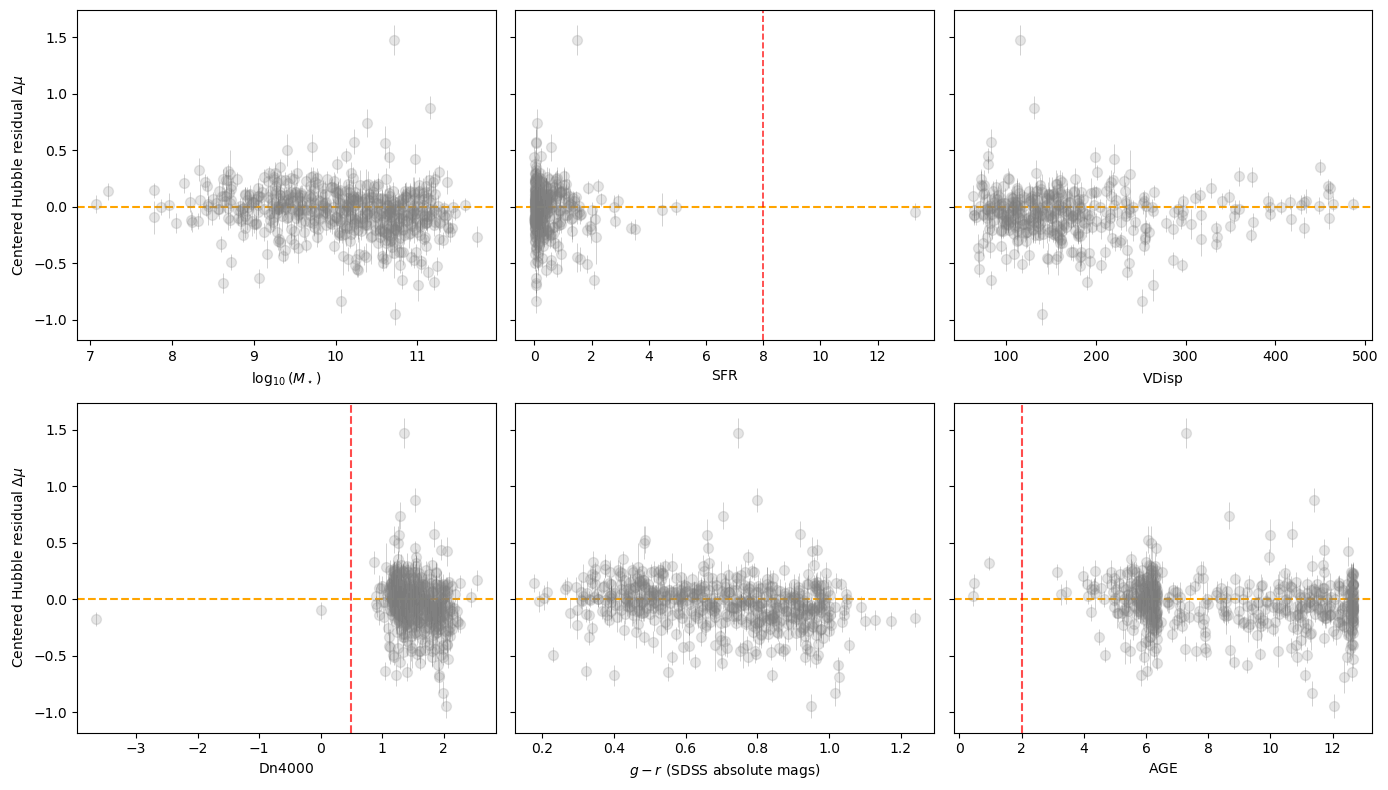

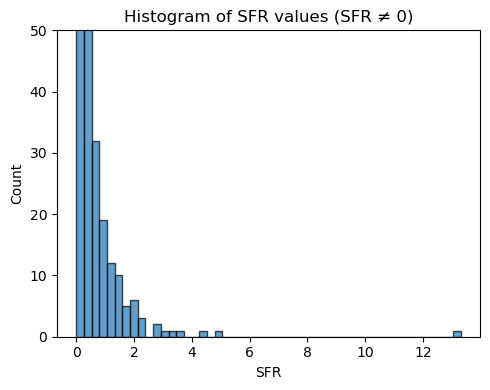

In [29]:
df = pd.read_csv("ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_with_residuals_with_musig.csv")

# -----------------------------------------------------
# DATA FILTER - Paper lccoverage_flag and fitquality_flag
# -------------------------------------------------------
print(len(df), "SNe before paper-based quality cuts.")
df = df[(df["lccoverage_flag"] == 1) & (df["fitquality_flag"] == 1)]
print(len(df), "SNe after paper-based quality cuts.")

# --------------------------------------
# Create g - r host-galaxy color
# --------------------------------------
df["SDSS_g_minus_r"] = df["ABSMAG01_SDSS_G"] - df["ABSMAG01_SDSS_R"]

# Read the Error Collumn for the distance modulus measurements.
yerr_all = df["sigma_mu_meas"]

# --------------------------------------
# Set up 2x3 grid
# --------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)
axes = axes.flatten()

point_kwargs = dict(alpha=0.2, s=50, color="grey", zorder=3)

# Helper funciton that plots the scatter and error bars. 
# ax - matplotlib axis where the plots will be drawn. 
# mask - the mask that selects which rows to use. 
# xcol - name of the df collumn to put on the x axis. Note residuals are always on the y-axis here. 
def scatter_with_errors(ax, mask, xcol):
    x = df.loc[mask, xcol].values
    y = df.loc[mask, "residual_centered"].values
    yerr = yerr_all.loc[mask].values

    # points
    ax.scatter(x, y, **point_kwargs)

    # error bars
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="none",               # no markers
        ecolor="black",
        elinewidth=0.5,
        alpha=0.25,
        zorder=2,
    )

    # Also plots a nice horizontal line to denote where the center is. 
    ax.axhline(0, linestyle="--", color="orange")
    return x, y


# --------------------------------------
# 1) LOGMSTAR
# --------------------------------------

ax = axes[0]

# Note the following is done as kind of an "in place" filter. 
# there are not actual infinite values of logmstar, but because we
# sometimes need to use a mask in order to 
mask_logm = np.isfinite(df["LOGMSTAR"]) 

# Use the helper function
x, y = scatter_with_errors(ax, mask_logm, "LOGMSTAR")

# Axis labels
ax.set_xlabel(r"$\log_{10}(M_\star)$")
ax.set_ylabel(r"Centered Hubble residual $\Delta \mu$")

# --------------------------------------
# 2) SFR (SFR != 0)
# --------------------------------------
ax = axes[1]
mask_sfr = (df["SFR"] != 0)
scatter_with_errors(ax, mask_sfr, "SFR")

# ---- vertical cut line at SFR = 8 ----
ax.axvline(
    8,
    color="red",
    linestyle="--",
    linewidth=1.2,
    alpha=0.8,
)

ax.set_xlabel(r"${\rm SFR}$")


# --------------------------------------
# 3) VDISP (VDISP != 125)
# --------------------------------------
ax = axes[2]
mask_vdisp = (df["VDISP"] != 125)
scatter_with_errors(ax, mask_vdisp, "VDISP")
ax.set_xlabel(r"${\rm VDisp}$")


# --------------------------------------
# 4) DN4000
# --------------------------------------
ax = axes[3]
mask = np.isfinite(df["DN4000"])
scatter_with_errors(ax, mask, "DN4000")

# vertical reference line
ax.axvline(0.5, linestyle="--", color="red", alpha=0.7)

ax.set_xlabel(r"${\rm Dn4000}$")
ax.set_ylabel(r"Centered Hubble residual $\Delta \mu$")


# --------------------------------------
# 5) SDSS g - r
# --------------------------------------
ax = axes[4]
mask = np.isfinite(df["SDSS_g_minus_r"])
scatter_with_errors(ax, mask, "SDSS_g_minus_r")
ax.set_xlabel(r"$g - r~{\rm (SDSS ~ absolute ~ mags)}$")


# --------------------------------------
# 6) AGE
# --------------------------------------
ax = axes[5]
mask = np.isfinite(df["AGE"])
scatter_with_errors(ax, mask, "AGE")

# vertical reference line at AGE = 2
ax.axvline(2, linestyle="--", color="red", alpha=0.7)

ax.set_xlabel(r"${\rm AGE}$")


# --------------------------------------
# Global cosmetics
# --------------------------------------


fig.tight_layout()

# --------------------------------------
# Histogram of SFR
# --------------------------------------
plt.figure(figsize=(5, 4))
sfr_hist = df.loc[mask_sfr, "SFR"].values
plt.hist(sfr_hist, bins=50, alpha=0.7, edgecolor="black")
plt.ylim(0, 50)
plt.xlabel("SFR")
plt.ylabel("Count")
plt.title("Histogram of SFR values (SFR ≠ 0)")
plt.tight_layout()
plt.show()

# Adding Binning Statistics and Further Quality Cuts #


### Further Quality Cuts: ###

- 'VDISP' - Stellar velocity dispersion. Note on this value from 'Dr. John Mustakas' --The velocity dispersion is only estimated when the data are "good
enough"; specifically, (a) there needs to be enough rest-wavelength
coverage in the DESI spectrum to span the 4000-A break (so I don't
waste time trying to derive vdisp from rest-frame UV ELG spectra,
where there's no information); and (b) I check whether delta-chi^2 is
$>25 when fitting with vdisp as a free parameter and if the fit doesn't
significantly improve, I adopt the default/nominal value of 125 km/s.

- "SFR" - Values that are equal to zero are removed. 

---

### Sigma Clipping ###


Sigma clipping identifies outliers by comparing each data point to the central
distribution of the sample. Specifically, the function `sigma_clip`:
	1.	Computes the median of the residuals, $\tilde{y}$.
	2.	Computes a robust estimate of the standard deviation, $\sigma$, typically derived
from the median absolute deviation (MAD).
	3.	Flags any point satisfying
$
|y_i - \tilde{y}| > 3\sigma
$
as an outlier.


---

### Binning Procedure and Error Propagation ###

For each bin in the host–property axis, we collect all supernova residuals $y_i$
whose corresponding host-galaxy values $x_i$ fall inside that bin.  
Let each residual have an associated measurement uncertainty $\sigma_i$.

We then calculate the inverse variance weight:

$
w_i = \frac{1}{\sigma_i^2}.
$

Then we do a weighed mean of the residuals:

$
\bar{y} =
\frac{\sum_i w_i , y_i}{\sum_i w_i}.
$

The uncertainty of the weighted mean is:

$
\sigma_{\bar{y}} =
\left( \sum_i w_i \right)^{-1/2}.
$


776 SNe before paper-based quality cuts.
579 SNe after paper-based quality cuts.


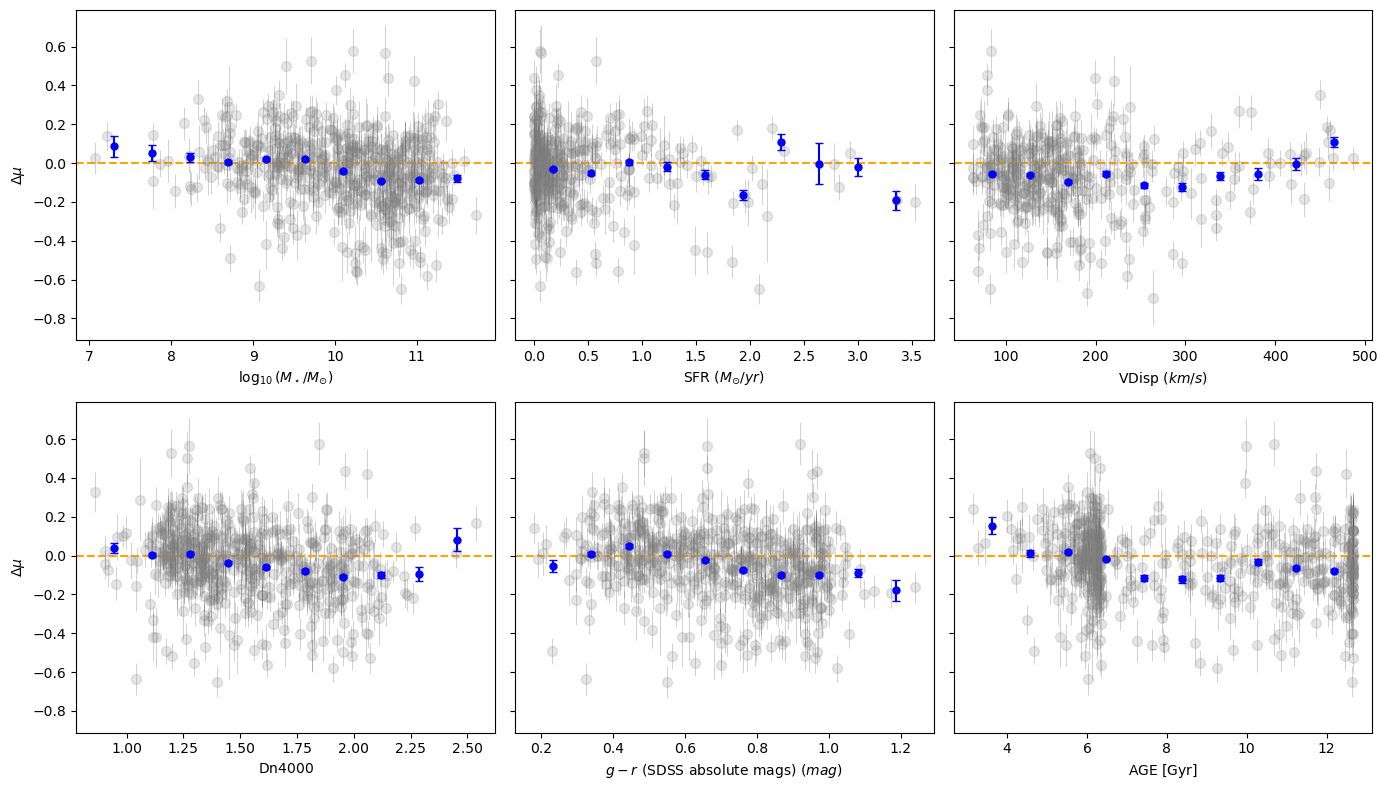

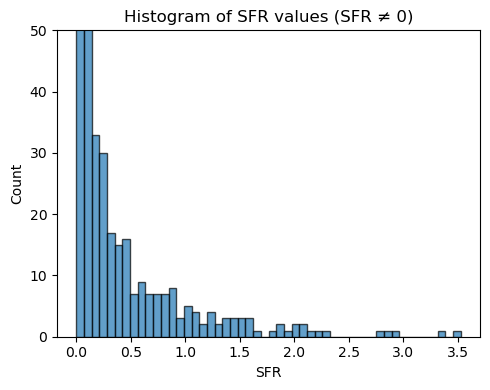

In [44]:
df = pd.read_csv("ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_with_residuals_with_musig.csv")

# -----------------------------------------------------
# DATA FILTER - Paper lccoverage_flag and fitquality_flag
# -------------------------------------------------------
print(len(df), "SNe before paper-based quality cuts.")
df = df[(df["lccoverage_flag"] == 1) & (df["fitquality_flag"] == 1)]
print(len(df), "SNe after paper-based quality cuts.")

# --------------------------------------
# Create g - r host-galaxy color
# --------------------------------------
df["SDSS_g_minus_r"] = df["ABSMAG01_SDSS_G"] - df["ABSMAG01_SDSS_R"]

# Read the Error Collumn for the distance modulus measurements.
yerr_all = df["sigma_mu_meas"]

# --------------------------------------
# Set up 2x3 grid
# --------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)
axes = axes.flatten()

point_kwargs = dict(alpha=0.2, s=50, color="grey", zorder=3)

# Helper funciton that plots the scatter and error bars. 
# ax - matplotlib axis where the plots will be drawn. 
# mask - the mask that selects which rows to use. 
# xcol - name of the df collumn to put on the x axis. Note residuals are always on the y-axis here.

def scatter_with_errors(ax, mask, xcol, nbins=None):
    # Raw values
    x = df.loc[mask, xcol].values
    y = df.loc[mask, "residual_centered"].values
    yerr = yerr_all.loc[mask].values

    # --- sigma clipping in y (vertical axis) ---
    clipped = sigma_clip(y, sigma=3, maxiters=1)
    mask_clip = ~clipped.mask  # True = keep point

    # apply clipping to x, y, yerr
    x = x[mask_clip]
    y = y[mask_clip]
    yerr = yerr[mask_clip]


    # --- scatter cloud ---
    ax.scatter(x, y, **point_kwargs)

    # --- individual error bars ---
    # Important to note that the way that this function works we will be drawing 
    # an error bar line from y - yerr to y + yerr. Where y_err = sigma_i
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="none",
        ecolor="black",
        elinewidth=0.5,
        alpha=0.25,
        zorder=2,
    )

    # horizontal reference
    ax.axhline(0, linestyle="--", color="orange")

    # --- BINNING WITH ERROR PROPAGATION ---
    # NOTE: we set the number of bins here. 

    # binned_statistic is a function tha takes (x, values, ststics, bins, range)
    # x - an array of positions along the x-axis.
    # values - the vaules on which the statistics are computed inside each bin. 
    # NOTE: here we want to just count the number of points in each bin on the 
    # horizontal axis of our plots. Therefore we parse "x" as both the argument and the 
    # value and simply choose "count" as our statistics option. 
    # bin_edges is an array of bin boundaries
    # binnumber - the index for which data point each bin belongs in.
    # This is done mostly becaue the data on the horizontal axis is not ranked so
    # we have to give it an identifier when we do our bin statistics later on. 
    # Bin centers are just calcualted as the middle points between one bin edge and another.
    
    _, bin_edges, binnumber = binned_statistic(x, x, statistic="count", bins=10) 
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Creating arrays for ht residuals. 
    binned_y = []
    binned_yerr = []

    # Just a fancy way of saying "for each bin"
    # We end up appending the data and error means into
    # an array. 
    for i in range(1, len(bin_edges)):
        in_bin = binnumber == i

        # We end up finding data and errro associated
        # with the number of bin that we are in. 
        y_bin = y[in_bin]
        err_bin = yerr[in_bin]
    
        # inverse-variance weights
        w = 1.0 / (err_bin**2)
    
        # weighted mean
        y_mean = np.sum(w * y_bin) / np.sum(w)
    
        # propagated error on the mean
        err_mean = 1.0 / np.sqrt(np.sum(w))
    
        binned_y.append(y_mean)
        binned_yerr.append(err_mean)

    ax.errorbar(
        bin_centers,
        binned_y,
        yerr=binned_yerr,
        fmt="o",
        color="blue",
        markersize=5,
        capsize=3,
        zorder = 5 # Keeps the data looking on top
    )
    

# --------------------------------------
# 1) LOGMSTAR
# --------------------------------------
ax = axes[0]

# finite values mask (same as before)
mask_logm = np.isfinite(df["LOGMSTAR"])

# Use helper function with binning ON
scatter_with_errors(ax, mask_logm, "LOGMSTAR", nbins)

# Axis labels
ax.set_xlabel(r"$\log_{10}(M_\star / M_{\odot})$")
ax.set_ylabel(r"$\Delta \mu$")

# --------------------------------------
# 2) SFR (cut SFR > 4 and SFR != 0)
# --------------------------------------
ax = axes[1]

# Exclude SFR = 0 AND exclude SFR > 4
mask_sfr = (df["SFR"] != 0) & (df["SFR"] <= 4)

scatter_with_errors(ax, mask_sfr, "SFR", nbins=nbins)

ax.set_xlabel(r"${\rm SFR}\ (M_{\odot}/yr)$")

# --------------------------------------
# 3) VDISP (VDISP != 125)
# --------------------------------------
ax = axes[2]

mask_vdisp = (df["VDISP"] != 125)

scatter_with_errors(ax, mask_vdisp, "VDISP", nbins=nbins)

ax.set_xlabel(r"${\rm VDisp }\  (km/s) $")


# --------------------------------------
# 4) DN4000  (cut DN4000 < 0.5)
# --------------------------------------
ax = axes[3]

# keep only finite values AND DN4000 >= 0.5
mask = np.isfinite(df["DN4000"]) & (df["DN4000"] >= 0.5)

scatter_with_errors(ax, mask, "DN4000", nbins=nbins)

ax.set_xlabel(r"${\rm Dn4000}$")
ax.set_ylabel(r"$\Delta \mu$")


# --------------------------------------
# 5) SDSS g - r
# --------------------------------------
ax = axes[4]

mask = np.isfinite(df["SDSS_g_minus_r"])

scatter_with_errors(ax, mask, "SDSS_g_minus_r", nbins=nbins)

ax.set_xlabel(r"$g - r~{\rm (SDSS ~ absolute ~ mags)}\ (mag)$")


# --------------------------------------
# 6) AGE  (cut AGE < 2)
# --------------------------------------
ax = axes[5]

# keep only finite AGE and AGE >= 2
mask = np.isfinite(df["AGE"]) & (df["AGE"] >= 2)

scatter_with_errors(ax, mask, "AGE", nbins=nbins)

ax.set_xlabel(r"${\rm AGE}\ [{\rm Gyr}]$")
# --------------------------------------
# Global cosmetics
# --------------------------------------


fig.tight_layout()

# --------------------------------------
# Histogram of SFR
# --------------------------------------
plt.figure(figsize=(5, 4))
sfr_hist = df.loc[mask_sfr, "SFR"].values
plt.hist(sfr_hist, bins=50, alpha=0.7, edgecolor="black")
plt.ylim(0, 50)
plt.xlabel("SFR")
plt.ylabel("Count")
plt.title("Histogram of SFR values (SFR ≠ 0)")
plt.tight_layout()
plt.show()

In [ ]:
Binned points LOGMSTAR Haha. 


# # --------------------------------------
# # 1) LOGMSTAR with binned points ONLY
# # --------------------------------------
# ax = axes[0]
# x = df["LOGMSTAR"].values
# y = df["residual_centered"].values

# print(len(x), "SNe in LOGMSTAR panel")

# # base gray cloud
# ax.scatter(x, y, **point_kwargs)
# ax.axhline(0, linestyle="--", color="orange")

# # ----- BINNING -----
# nbins = 10  # choose number of bins
# stat, bin_edges, _ = binned_statistic(x, y, statistic="median", bins=nbins)

# # compute bin centers
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# # plot the binned median points
# ax.scatter(
#     bin_centers,
#     stat,
#     s=60,            # size of binned points
#     c="blue",
#     zorder=10
# )

# # optional vertical lines showing the bin boundaries
# ymin, ymax = ax.get_ylim()
# for edge in bin_edges:
#     ax.vlines(edge, ymin, ymax, lw=0.5, alpha=0.15)

# # labels
# ax.set_xlabel(r"$\log_{10}(M_\star)$")
# ax.set_ylabel(r"Centered Hubble residual $\Delta \mu$")

# SPEARMAN RHO AND P-VALUE CALCUTLATIONS #

In [37]:
print(df) # Just printing the content of the data frame. 

     Unnamed: 0       ztfname  redshift  redshift_err source            t0  \
0            19  ZTF18aabyhlc  0.029055      0.000015  z_gal  58180.621262   
3            26  ZTF18aagrtxs  0.029741      0.000011  z_gal  58213.150268   
5            47  ZTF18aahqmsr  0.062102      0.000010  z_gal  58233.976974   
8            61  ZTF18aairuad  0.064662      0.000011  z_gal  58229.202799   
9            67  ZTF18aaixjrc  0.106079      0.000016  z_gal  58900.698562   
..          ...           ...       ...           ...    ...           ...   
767        3600  ZTF20acyzsol  0.057989      0.000010  z_gal  59219.039451   
769        3612  ZTF20adadshh  0.024565      0.000010  z_gal  59220.934923   
770        3619   ZUDS20dofxx  0.270355      0.000100  z_gal  58879.720310   
771        3620   ZUDS20dpvgu  0.287793      0.000080  z_gal  58888.132311   
774        3624  ZTF18aczeraq  0.058635      0.000011  z_gal  58483.107214   

           x0        x1         c    t0_err  ...      ABS_DIFF 

In [42]:
# --------------------------------------
# Spearman correlations (computed one by one)
# --------------------------------------

# --- 1) SFR vs residual_centered (with same filter & x sigma-clip) ---
mask_sfr = (df["SFR"] != 0)
x_sfr_raw = df.loc[mask_sfr, "SFR"].values
y_sfr_raw = df.loc[mask_sfr, "residual_centered"].values

x_sfr_clipped = sigma_clip(x_sfr_raw, sigma=3, maxiters=5)
mask_sfr_clean = ~x_sfr_clipped.mask

x_sfr = x_sfr_raw[mask_sfr_clean]
y_sfr = y_sfr_raw[mask_sfr_clean]

rho_sfr, p_sfr = spearmanr(x_sfr, y_sfr, nan_policy="omit")


# --- 2) DN4000 vs residual_centered (with x sigma-clip) ---
x_dn_raw = df["DN4000"].values
y_dn_raw = df["residual_centered"].values

x_dn_clipped = sigma_clip(x_dn_raw, sigma=3, maxiters=5)
mask_dn_clean = ~x_dn_clipped.mask

x_dn = x_dn_raw[mask_dn_clean]
y_dn = y_dn_raw[mask_dn_clean]

rho_dn, p_dn = spearmanr(x_dn, y_dn, nan_policy="omit")


# --- 3) VDISP vs residual_centered (drop VDISP == 125) ---
mask_vdisp = (df["VDISP"] != 125)

x_vdisp = df.loc[mask_vdisp, "VDISP"].values
y_vdisp = df.loc[mask_vdisp, "residual_centered"].values

rho_vdisp, p_vdisp = spearmanr(x_vdisp, y_vdisp, nan_policy="omit")

# --- 4) LOGMSTAR vs residual_centered (no sigma-clip) ---
x_logm = df["LOGMSTAR"].values
y_logm = df["residual_centered"].values

rho_logm, p_logm = spearmanr(x_logm, y_logm, nan_policy="omit")


# --- 5) SDSS_g_minus_r vs residual_centered (no sigma-clip) ---
x_gr = df["SDSS_g_minus_r"].values
y_gr = df["residual_centered"].values

rho_gr, p_gr = spearmanr(x_gr, y_gr, nan_policy="omit")


# --------------------------------------
# Spearman correlation table (no loops)
# --------------------------------------
corr_table = pd.DataFrame({
    "x_variable": ["SFR", "DN4000", "VDISP", "LOGMSTAR", "SDSS_g_minus_r"],
    "rho":        [rho_sfr, rho_dn, rho_vdisp, rho_logm, rho_gr],
    "p_value":    [p_sfr,   p_dn,   p_vdisp,   p_logm,   p_gr],
})


print("\nSpearman correlation summary:")
print(corr_table.to_string(index=False))



# def add_lowess(ax, x, y, frac=0.3):
#     """Add a LOWESS trend line to an axis."""
#     x = np.asarray(x)
#     y = np.asarray(y)
#     mask = np.isfinite(x) & np.isfinite(y)
#     if mask.sum() < 5:
#         return None
#     smoothed = lowess(y[mask], x[mask], frac=frac, return_sorted=True)
#     ax.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2, color="red", label="LOWESS")

# def compute_spearman(x, y):
#     """Compute Spearman correlation (no plotting)."""
#     x = np.asarray(x)
#     y = np.asarray(y)
#     mask = np.isfinite(x) & np.isfinite(y)
#     if mask.sum() < 5:
#         rho, pval = np.nan, np.nan
#     else:
#         rho, pval = spearmanr(x[mask], y[mask])
#     return rho, pval


Spearman correlation summary:
    x_variable       rho      p_value
           SFR -0.020191 7.127141e-01
        DN4000 -0.274477 2.135556e-11
         VDISP -0.028262 5.715875e-01
      LOGMSTAR -0.239085 5.703622e-09
SDSS_g_minus_r -0.287747 1.680138e-12


# LOADS DESIRED DATA FROM DESI GALAXY SURVEY #

In [5]:
from astropy.io import fits

# Path to the FastSpecFit file
fastspecfit_path = "/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron-main-dark.fits"

# Open and inspect the FITS file
with fits.open(fastspecfit_path) as hdul:
    for i, hdu in enumerate(hdul):
        if isinstance(hdu, fits.BinTableHDU):
            columns = hdu.columns.names
            print(f"\n📁 HDU {i}: {hdu.name}")
            print("📋 Columns:")
            print(columns)
            print(len(columns))


📁 HDU 1: FASTSPEC
📋 Columns:
['TARGETID', 'SURVEY', 'PROGRAM', 'HEALPIX', 'Z', 'COEFF', 'RCHI2', 'RCHI2_CONT', 'RCHI2_PHOT', 'SNR_B', 'SNR_R', 'SNR_Z', 'SMOOTHCORR_B', 'SMOOTHCORR_R', 'SMOOTHCORR_Z', 'VDISP', 'VDISP_IVAR', 'AV', 'AGE', 'ZZSUN', 'LOGMSTAR', 'SFR', 'DN4000', 'DN4000_OBS', 'DN4000_IVAR', 'DN4000_MODEL', 'FLUX_SYNTH_G', 'FLUX_SYNTH_R', 'FLUX_SYNTH_Z', 'FLUX_SYNTH_SPECMODEL_G', 'FLUX_SYNTH_SPECMODEL_R', 'FLUX_SYNTH_SPECMODEL_Z', 'FLUX_SYNTH_PHOTMODEL_G', 'FLUX_SYNTH_PHOTMODEL_R', 'FLUX_SYNTH_PHOTMODEL_Z', 'FLUX_SYNTH_PHOTMODEL_W1', 'FLUX_SYNTH_PHOTMODEL_W2', 'FLUX_SYNTH_PHOTMODEL_W3', 'FLUX_SYNTH_PHOTMODEL_W4', 'ABSMAG10_DECAM_G', 'ABSMAG10_IVAR_DECAM_G', 'KCORR10_DECAM_G', 'ABSMAG10_DECAM_R', 'ABSMAG10_IVAR_DECAM_R', 'KCORR10_DECAM_R', 'ABSMAG10_DECAM_Z', 'ABSMAG10_IVAR_DECAM_Z', 'KCORR10_DECAM_Z', 'ABSMAG00_U', 'ABSMAG00_IVAR_U', 'KCORR00_U', 'ABSMAG00_B', 'ABSMAG00_IVAR_B', 'KCORR00_B', 'ABSMAG00_V', 'ABSMAG00_IVAR_V', 'KCORR00_V', 'ABSMAG01_SDSS_U', 'ABSMAG01_IVAR_SDSS

In [6]:
from astropy.io import fits

with fits.open(fastspecfit_path) as hdul:
    print(hdul)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fafd44964d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fafe28c8510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7faff76849d0>]


In [7]:
fits.info(fastspecfit_path)

Filename: /global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron-main-dark.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  FASTSPEC      1 BinTableHDU   1826   10075557R x 907C   [K, 4A, 4A, J, D, 40E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, E, E, E, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E

In [8]:
from astropy.io import fits

with fits.open(fastspecfit_path) as hdul:
    for i, hdu in enumerate(hdul):
        print(f"\n=== HDU {i}: {hdu.name} ===")
        if isinstance(hdu, fits.BinTableHDU):
            print("Columns:")
            print(hdu.columns.names)
            print(f"Number of columns: {len(hdu.columns)}")
        else:
            print("Not a table HDU")


=== HDU 0: PRIMARY ===
Not a table HDU

=== HDU 1: FASTSPEC ===
Columns:
['TARGETID', 'SURVEY', 'PROGRAM', 'HEALPIX', 'Z', 'COEFF', 'RCHI2', 'RCHI2_CONT', 'RCHI2_PHOT', 'SNR_B', 'SNR_R', 'SNR_Z', 'SMOOTHCORR_B', 'SMOOTHCORR_R', 'SMOOTHCORR_Z', 'VDISP', 'VDISP_IVAR', 'AV', 'AGE', 'ZZSUN', 'LOGMSTAR', 'SFR', 'DN4000', 'DN4000_OBS', 'DN4000_IVAR', 'DN4000_MODEL', 'FLUX_SYNTH_G', 'FLUX_SYNTH_R', 'FLUX_SYNTH_Z', 'FLUX_SYNTH_SPECMODEL_G', 'FLUX_SYNTH_SPECMODEL_R', 'FLUX_SYNTH_SPECMODEL_Z', 'FLUX_SYNTH_PHOTMODEL_G', 'FLUX_SYNTH_PHOTMODEL_R', 'FLUX_SYNTH_PHOTMODEL_Z', 'FLUX_SYNTH_PHOTMODEL_W1', 'FLUX_SYNTH_PHOTMODEL_W2', 'FLUX_SYNTH_PHOTMODEL_W3', 'FLUX_SYNTH_PHOTMODEL_W4', 'ABSMAG10_DECAM_G', 'ABSMAG10_IVAR_DECAM_G', 'KCORR10_DECAM_G', 'ABSMAG10_DECAM_R', 'ABSMAG10_IVAR_DECAM_R', 'KCORR10_DECAM_R', 'ABSMAG10_DECAM_Z', 'ABSMAG10_IVAR_DECAM_Z', 'KCORR10_DECAM_Z', 'ABSMAG00_U', 'ABSMAG00_IVAR_U', 'KCORR00_U', 'ABSMAG00_B', 'ABSMAG00_IVAR_B', 'KCORR00_B', 'ABSMAG00_V', 'ABSMAG00_IVAR_V', 'KCORR0